### evaluating the output forecastings

output of forecastings format:

    carno	startlap	startrank	endrank	diff	sign	pred_endrank	pred_diff	pred_sign	endlap	pred_endlap
      11	12	31	3.0	5.0	2.0	1	1.0	-2.0	-1	49	58
    
refer to:
    19.RankNet/stage_model_regressor.ipynb
    19.RankNet/RankForecasting-stint-paper-1kpitmodel.ipynb

In [309]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import mxnet as mx
from mxnet import gluon
import pickle
import json
import random
import inspect
from scipy import stats
from sklearn.metrics import mean_squared_error
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#from indycar.model.stint_predictor_fastrun import *
#import indycar.model.stint_simulator as stint
#import indycar.model.stint_simulator_shortterm_pitmodel as stint
import indycar.model.stint_simulator_paper as stint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of certifi failed: Traceback (most recent call last):
  File "/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/certifi/__init__.py", line 1, in <

In [310]:
#straight implementation of prisk
def quantile_loss(target, quantile_forecast, q):
    return 2.0 * np.nansum(
        np.abs(
            (quantile_forecast - target)
            * ((target <= quantile_forecast) - q)
        )
    )

def abs_target_sum(target): 
    return np.nansum(np.abs(target)) 

def prisk(full_samples, full_tss, verbose = False):
    """
    calculate prisk by convert <samples, tss> into gluonts format
    
    """
    carlist = full_tss.keys()
    tss = []
    forecasts = []
    forecasts_mean = []
    freq = '1min'
    start = pd.Timestamp("01-01-2019", freq=freq) 

    for car in carlist:
        testcar = car
        fc = SampleForecast(samples = full_samples[testcar][:, 12:], freq=freq, start_date=start + 12)

        samples = np.mean(full_samples[testcar][:, 12:], axis =0, keepdims=True)
        fc_mean = SampleForecast(samples = samples, freq=freq, start_date=start + 12)

        index = pd.date_range(start='2019-01-01 00:00:00', freq = 'T', periods = len(full_tss[testcar]))
        ts = pd.DataFrame(index = index, data = full_tss[testcar])    

        tss.append(ts)
        forecasts.append(fc)
        forecasts_mean.append(fc_mean)

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(tss))
    if verbose:
        print(json.dumps(agg_metrics, indent=4))  
    
    print(agg_metrics["wQuantileLoss[0.1]"], agg_metrics["wQuantileLoss[0.5]"],agg_metrics["wQuantileLoss[0.9]"])
    
    return agg_metrics

def prisk_direct_bysamples(full_samples, full_tss, quantiles=[0.1,0.5,0.9], startid = 12, verbose=False):
    """
    calculate prisk by <samples, tss> directly (equal to gluonts implementation)
    
    target: endrank
    forecast: pred_endrank
    item_id: <carno, startlap>
    """
    
    carlist = full_tss.keys()
    
    prisk = np.zeros((len(carlist), len(quantiles)))
    target_sum = np.zeros((len(carlist)))
    aggrisk = np.zeros((len(quantiles)))
    
    for carid, carno in enumerate(carlist):

        # for this car
        forecast = full_samples[carno]
        target = full_tss[carno]
        
        #calc quantiles
        # len(quantiles) x 1
        quantile_forecasts = np.quantile(forecast, quantiles, axis=0)
        
        for idx, q in enumerate(quantiles):
            q_forecast = quantile_forecasts[idx]
            prisk[carid, idx] = quantile_loss(target[startid:], q_forecast[startid:], q)
            target_sum[carid] = abs_target_sum(target[startid:])
            
        if verbose==True and carno==3:
            print('target:', target[startid:])
            print('forecast:', q_forecast[startid:])
            print('target_sum:', target_sum[carid])
            
            print('quantile_forecasts:', quantile_forecasts[:,startid:])
        
    #agg
    #aggrisk = np.mean(prisk, axis=0)
    prisk_sum = np.nansum(prisk, axis=0)
    if verbose==True:
        print('prisk:',prisk)
        print('prisk_sum:',prisk_sum)
        print('target_sum:',target_sum)
    for idx, q in enumerate(quantiles):
        aggrisk[idx] = np.divide(prisk_sum[idx], np.sum(target_sum))
    
    agg_metrics = {}
    for idx, q in enumerate(quantiles):
        agg_metrics[f'wQuantileLoss[{q}]'] = aggrisk[idx]
        
    print(agg_metrics.values())
    
    return agg_metrics, aggrisk

def df2samples(dfall, prediction_len=2, samplecnt=1):
    """
    convert a df into <samples, tss> format
    
    this version works for the output of ml modles which contains only 1 sample
    """
    carlist = set(dfall.carno.values)
    full_samples = {}
    full_tss = {}

    startlaps = {}
    for car in carlist:
        startlaps[car] = set(dfall[dfall['carno']==car].startlap.values)
        
    #empty samples
    for carid, carno in enumerate(carlist):
        full_tss[carno] = np.zeros((200))
        full_tss[carno][:] = np.nan
        full_samples[carno] = np.zeros((samplecnt,200))
        full_samples[carno][:] = np.nan
        
        for startlap in startlaps[carno]:
            dfrec = dfall[(dfall['carno']==carno) & (dfall['startlap']==startlap)]
            
            curlap = int(dfrec.startlap.values[0] + prediction_len)
            target = dfrec.endrank.values[0]
            forecast = dfrec.pred_endrank.values[0]
            
            for idx in range(samplecnt):
                full_samples[carno][idx,curlap] = forecast
                
            full_tss[carno][curlap] = target
    
    return full_samples, full_tss
            
def df2samples(dfall, prediction_len=2, samplecnt=1):
    """
    convert a df into <samples, tss> format
    
    this version works for the output of ml modles which contains only 1 sample
    """
    carlist = set(dfall.carno.values)
    full_samples = {}
    full_tss = {}

    startlaps = {}
    for car in carlist:
        startlaps[car] = set(dfall[dfall['carno']==car].startlap.values)
        
    #empty samples
    for carid, carno in enumerate(carlist):
        full_tss[carno] = np.zeros((200))
        full_tss[carno][:] = np.nan
        full_samples[carno] = np.zeros((samplecnt,200))
        full_samples[carno][:] = np.nan
        
        for startlap in startlaps[carno]:
            dfrec = dfall[(dfall['carno']==carno) & (dfall['startlap']==startlap)]
            
            curlap = int(dfrec.startlap.values[0] + prediction_len)
            target = dfrec.endrank.values[0]
            forecast = dfrec.pred_endrank.values[0]
            
            for idx in range(samplecnt):
                full_samples[carno][idx,curlap] = forecast
                
            full_tss[carno][curlap] = target
    
    return full_samples, full_tss
    
    
def runs2samples(runret, errlist):
    """
    for stint results only
    
    get samples from the runs
    
    input:
        runret  ; list of result df <carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap>
        errlist ; <car, startlap> list
    return:
        samples, tss
    """
    samplecnt = len(runret)
    carlist = set(runret[0].carno.values)
    full_samples = {}
    full_tss = {}
    
    #concat all dfs
    dfall = pd.concat(runret)
    
    
    startlaps = {}
    for car in carlist:
        startlaps[car] = set(dfall[dfall['carno']==car].startlap.values)
        
    #empty samples
    for carid, carno in enumerate(carlist):
        full_tss[carno] = np.zeros((200))
        full_tss[carno][:] = np.nan
        full_samples[carno] = np.zeros((samplecnt,200))
        full_samples[carno][:] = np.nan
        
        for startlap in startlaps[carno]:
            
            thisrec = [carno,startlap]
            if thisrec in errlist:
                continue
            
            dfrec = dfall[(dfall['carno']==carno) & (dfall['startlap']==startlap)]
            
            curlap = int(dfrec.startlap.values[0])
            target = dfrec.endrank.values[0]
            forecast = dfrec.pred_endrank.to_numpy()
            
            #if carno==12:
            #    print('forecast.shape', forecast.shape)
            
            full_samples[carno][:,curlap] = forecast
                
            full_tss[carno][curlap] = target
    
    return full_samples, full_tss    



def runs2samples_ex(runret, errlist):
    """
    for stint results only
    
    get samples from the runs
    
    input:
        runret  ; list of result df <carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap>
        errlist ; <car, startlap> list
    return:
        samples, tss
    """
    samplecnt = len(runret)
    print('run2samples_ex, samplecnt:', samplecnt)
    
    full_samples = {}
    full_tss = {}
    
    #concat all dfs
    dfs = []
    for run in runret:
        dfs.append(runret[run][0])
    dfall = pd.concat(dfs)
    
    carlist = set(dfall.carno.values)
    
    startlaps = {}
    for car in carlist:
        startlaps[car] = set(dfall[dfall['carno']==car].startlap.values)
        
    #empty samples
    for carid, carno in enumerate(carlist):
        full_tss[carno] = np.zeros((200))
        full_tss[carno][:] = np.nan
        full_samples[carno] = np.zeros((samplecnt,200))
        full_samples[carno][:] = np.nan
        
        for startlap in startlaps[carno]:
            
            thisrec = [carno,startlap]
            if thisrec in errlist:
                continue
            
            dfrec = dfall[(dfall['carno']==carno) & (dfall['startlap']==startlap)]
            
            curlap = int(dfrec.startlap.values[0])
            target = dfrec.endrank.values[0]
            forecast = dfrec.pred_endrank.to_numpy()
            
            #if carno==12:
            #    print('forecast.shape', forecast.shape)
            
            full_samples[carno][:,curlap] = forecast
                
            full_tss[carno][curlap] = target
    
    return full_samples, full_tss  

def df2samples_ex(dfall, samplecnt=100,errlist=[]):
    """
    for stint results only
    
    get samples from the runs
    
    input:
        runret  ; list of result df <carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap>
        errlist ; <car, startlap> list
    return:
        samples, tss
    """
    #samplecnt = len(runret)
    full_samples = {}
    full_tss = {}
    
    carlist = set(dfall.carno.values)
    
    startlaps = {}
    for car in carlist:
        startlaps[car] = set(dfall[dfall['carno']==car].startlap.values)
        
    #empty samples
    for carid, carno in enumerate(carlist):
        full_tss[carno] = np.zeros((200))
        full_tss[carno][:] = np.nan
        full_samples[carno] = np.zeros((samplecnt,200))
        full_samples[carno][:] = np.nan
        
        for startlap in startlaps[carno]:
            
            thisrec = [carno,startlap]
            if thisrec in errlist:
                continue
            
            dfrec = dfall[(dfall['carno']==carno) & (dfall['startlap']==startlap)]
            
            curlap = int(dfrec.startlap.values[0])
            target = dfrec.endrank.values[0]
            forecast = dfrec.pred_endrank.to_numpy()
            
            #if carno==12:
            #    print('forecast.shape', forecast.shape)
            
            full_samples[carno][:,curlap] = forecast
                
            full_tss[carno][curlap] = target
    
    return full_samples, full_tss   

In [311]:

#
# following functions works for short-term results only
# 

#def get_allsamples(year=2018, model='pitmodel'):
def get_allsamples_ex(dfx):
    """
    dfx is the results of multiple runs, ret of test_model call
    dfx[runid] -> < df, samples, tss>
    """
    runs = list(dfx.keys())
    runcnt = len(runs)
    
    full_samples = {}
    full_tss = dfx[runs[0]][2]
    carlist = list(full_tss.keys())
    samplecnt, lapcnt = dfx[runs[0]][1][carlist[0]].shape
    
    print('sacmplecnt:', samplecnt, 'lapcnt:',lapcnt,'runcnt:', runcnt)
    
    #empty samples
    for carid, carno in enumerate(carlist):
        full_samples[carno] = np.zeros((runcnt, lapcnt))
    
    for runid in runs:
        #one run
        tss = dfx[runid][2]
        forecast = dfx[runid][1]
        
        for carid, carno in enumerate(carlist):
            #get mean for this run
            forecast_mean = np.nanmean(forecast[carno], axis=0)
            full_samples[carno][runid, :] = forecast_mean
            
            #if carno==3 and runid == 0:
            #    print('forecast:',forecast_mean)
            
    return full_samples, full_tss

   
def get_allsamples(year=2018, model='pitmodel'):    
    dfx = ret[f'{model}-RANK-{year}-inlap-nopitage']
    return get_allsamples_ex(dfx)

def do_rerank(dfout, short=True):
    """
    carno','startlap','startrank','endrank','diff','sign','pred_endrank','pred_diff','pred_sign','endlap','pred_endlap
    
    output of prediction of target can be float
    
    resort the endrank globally
    
    """
    
    cols=['carno','startlap','startrank','endrank','diff','sign','pred_endrank','pred_diff','pred_sign','endlap','pred_endlap']
    colid={x:id for id,x in enumerate(cols)}
    
    #df = dfout.sort_values(by=['startlap','carno'])
    print('rerank...')
    laps = set(dfout.startlap.values)
    
    dfs = []
    for lap in laps:
        df = dfout[dfout['startlap']==lap].to_numpy()
        
        #print('in',df)
        
        idx = np.argsort(df[:,colid['pred_endrank']], axis=0)
        true_rank = np.argsort(idx, axis=0)
    
        df[:,colid['pred_endrank']] = true_rank
        
        #reset preds 
        df[:,colid['pred_diff']] = df[:,colid['pred_endrank']] - df[:,colid['endrank']]

        for rec in df:
            if rec[colid['pred_diff']] == 0:
                rec[colid['pred_sign']] = 0
            elif rec[colid['pred_diff']] > 0:
                rec[colid['pred_sign']] = 1
            else:
                rec[colid['pred_sign']] = -1        
        
        #print('out',df)
        if len(dfs) == 0:
            dfs = df
        else:
            dfs = np.vstack((dfs, df))
        #dfs.append(df)
        #np.vstack(df)
        
    #dfret = pd.concat(dfs)
    #data = np.array(dfs)
    if short:
        dfret = pd.DataFrame(dfs.astype(int), columns = cols[:-2])
    else:
        dfret = pd.DataFrame(dfs.astype(int), columns = cols)
    return dfret

In [312]:
def load_dfout(datafile):
    datafile = '../result/22.PaperFinal/' + datafile  
    #with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        
        return dfout[0]
    
def load_dfout_all(datafile):
    #with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
    datafile = '../result/22.PaperFinal/' + datafile  
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        
        return dfout

### evalute stint restuls

In [313]:
### load ml models
_trim = 0
_include_final = True
_include_stintlen = True
#_include_stintlen = False
include_str = '1' if _include_final else '0'
stint_str = '1' if _include_stintlen else ''
#outfile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}.pickle'
#preddf = load_dfout(outfile)
#outfile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-oracle-t{_trim}.pickle'
#preddf_oracle = load_dfout(outfile)

In [335]:
outfile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}-newtry-tuned.pickle'
preddf = load_dfout(outfile)
outfile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-oracle-t{_trim}-newtry-tuned.pickle'
preddf_oracle = load_dfout(outfile)

In [341]:
outfile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}-tuned.pickle'
preddf = load_dfout(outfile)
outfile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-oracle-t{_trim}-tuned.pickle'
preddf_oracle = load_dfout(outfile)

In [336]:
dfout = preddf['2018']
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    stint.get_evalret(df)


model: currank
model: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.00}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: avgrank
model: acc={0.32}, mae={7.21}, rmse={9.38},r2={-1.66}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: dice
model: acc={0.38}, mae={6.56}, rmse={8.57},r2={-0.94}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: lasso
model: acc={0.57}, mae={3.56}, rmse={4.79},r2={-3.90}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: ridge
model: acc={0.59}, mae={3.38}, rmse={4.61},r2={-1.95}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: rf
model: acc={0.58}, mae={3.56}, rmse={4.86},r2={-4.09}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: svr_rbf
model: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.00}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: svr_lin
model: acc={

In [337]:
df = preddf['2018']['svr_lin']
df[df['carno']==12]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
39,12,31,3,5,2,1,4,1,1
40,12,49,5,0,-5,-1,5,0,0
41,12,93,0,1,1,1,2,2,1
42,12,128,1,7,6,1,3,2,1
43,12,170,7,0,-7,-1,5,-2,-1


In [338]:
dfout = preddf['2019']
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    stint.get_evalret(df)

model: currank
model: acc={0.15}, mae={4.29}, rmse={6.46},r2={0.00}, {216}
            naive: acc={0.15}, mae={4.29}, rmse={6.46},r2={0.44}
model: avgrank
model: acc={0.37}, mae={7.93}, rmse={11.07},r2={-1.32}, {216}
            naive: acc={0.15}, mae={4.29}, rmse={6.46},r2={0.44}
model: dice
model: acc={0.48}, mae={6.20}, rmse={8.64},r2={-1.08}, {216}
            naive: acc={0.15}, mae={4.29}, rmse={6.46},r2={0.44}
model: lasso
model: acc={0.51}, mae={4.14}, rmse={5.75},r2={-3.07}, {216}
            naive: acc={0.15}, mae={4.29}, rmse={6.46},r2={0.44}
model: ridge
model: acc={0.52}, mae={4.22}, rmse={5.75},r2={-1.72}, {216}
            naive: acc={0.15}, mae={4.29}, rmse={6.46},r2={0.44}
model: rf
model: acc={0.51}, mae={4.15}, rmse={5.76},r2={-2.67}, {216}
            naive: acc={0.15}, mae={4.29}, rmse={6.46},r2={0.44}
model: svr_rbf
model: acc={0.15}, mae={4.29}, rmse={6.46},r2={0.00}, {216}
            naive: acc={0.15}, mae={4.29}, rmse={6.46},r2={0.44}
model: svr_lin
model: acc=

In [317]:
# load ranknet results
# outfile=f'stint-dfout-ranknet-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}.pickle'
outfile = 'stint-dfout-ranknet-indy500-timediff-noinlap-nopitage-20182019-alldata.pickle'
ranknetdf, ranknet_acc, ranknet_ret  = load_dfout(outfile)

In [318]:
ranknetdf['2018'].keys()

dict_keys(['pitmodel_mode', 'pitmodel_mean', 'pitmodel_median', 'oracle_mode', 'oracle_mean', 'oracle_median'])

In [319]:
len(ranknet_ret['oracle-TIMEDIFF-2018-noinlap-nopitage'])

10

In [320]:
ranknet_ret['oracle-TIMEDIFF-2018-noinlap-nopitage'][0]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
0,13,28,20.0,12.0,-8.0,-1,13.0,-7.0,-1,49,49
1,14,29,10.0,1.0,-9.0,-1,6.0,-4.0,-1,49,49
2,59,29,32.0,22.0,-10.0,-1,26.0,-6.0,-1,52,52
3,3,30,10.0,4.0,-6.0,-1,6.0,-4.0,-1,49,49
4,20,30,7.0,0.0,-7.0,-1,0.0,-7.0,-1,49,49
...,...,...,...,...,...,...,...,...,...,...,...
184,25,195,16.0,14.0,-2.0,-1,15.0,-1.0,-1,199,199
185,59,195,21.0,21.0,0.0,0,21.0,0.0,0,197,197
186,60,195,17.0,15.0,-2.0,-1,16.0,-1.0,-1,199,199
187,19,196,15.0,18.0,3.0,1,17.0,2.0,1,198,198


In [321]:
dfout = ranknetdf['2018']
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    stint.get_evalret(df)

model: pitmodel_mode
model: acc={0.54}, mae={3.95}, rmse={5.73},r2={-1.42}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: pitmodel_mean
model: acc={0.67}, mae={3.74}, rmse={5.49},r2={-1.48}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: pitmodel_median
model: acc={0.57}, mae={3.81}, rmse={5.60},r2={-1.38}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: oracle_mode
model: acc={0.69}, mae={3.29}, rmse={4.94},r2={-0.37}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: oracle_mean
model: acc={0.72}, mae={3.22}, rmse={4.84},r2={-0.40}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: oracle_median
model: acc={0.70}, mae={3.25}, rmse={4.88},r2={-0.40}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}


In [322]:
dfout = ranknetdf['2019']
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    stint.get_evalret(df)

model: pitmodel_mode
model: acc={0.51}, mae={4.49}, rmse={6.37},r2={-1.23}, {215}
            naive: acc={0.16}, mae={4.26}, rmse={6.46},r2={0.43}
model: pitmodel_mean
model: acc={0.61}, mae={4.36}, rmse={6.17},r2={-0.87}, {215}
            naive: acc={0.16}, mae={4.26}, rmse={6.46},r2={0.43}
model: pitmodel_median
model: acc={0.54}, mae={4.41}, rmse={6.26},r2={-0.97}, {215}
            naive: acc={0.16}, mae={4.26}, rmse={6.46},r2={0.43}
model: oracle_mode
model: acc={0.64}, mae={3.62}, rmse={5.41},r2={-0.08}, {215}
            naive: acc={0.16}, mae={4.26}, rmse={6.46},r2={0.43}
model: oracle_mean
model: acc={0.66}, mae={3.58}, rmse={5.34},r2={-0.11}, {215}
            naive: acc={0.16}, mae={4.26}, rmse={6.46},r2={0.43}
model: oracle_median
model: acc={0.64}, mae={3.58}, rmse={5.35},r2={-0.08}, {215}
            naive: acc={0.16}, mae={4.26}, rmse={6.46},r2={0.43}


In [323]:
ranknetdf['2018']['pitmodel_mean']

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
0,1.0,100.0,8.0,7.0,-1.0,-1.0,10.75,2.75,1.0,134.0,126.0
1,1.0,69.0,8.0,8.0,0.0,0.0,5.98,-2.02,-1.0,100.0,97.0
2,1.0,134.0,7.0,16.0,9.0,1.0,7.45,0.45,1.0,169.0,164.0
3,1.0,169.0,16.0,7.0,-9.0,-1.0,14.81,-1.19,-1.0,199.0,198.0
4,1.0,49.0,2.0,8.0,6.0,1.0,5.17,3.17,1.0,69.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...
184,98.0,169.0,13.0,11.0,-2.0,-1.0,11.81,-1.19,-1.0,199.0,199.0
185,98.0,49.0,9.0,14.0,5.0,1.0,9.26,0.26,1.0,91.0,78.0
186,98.0,91.0,14.0,9.0,-5.0,-1.0,17.33,3.33,1.0,124.0,116.0
187,98.0,124.0,9.0,13.0,4.0,1.0,10.90,1.90,1.0,169.0,155.0


In [324]:
### stint result, just cannot do rerank, 
### instead use int()
df = do_rerank(ranknetdf['2018']['pitmodel_mean'],short=False)
stint.get_evalret(df)

rerank...
model: acc={0.49}, mae={14.27}, rmse={16.83},r2={-3.43}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}


array([[ 0.48677249, 14.26984127, 16.83046494, -3.43386337],
       [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]])

### sync with the dataset

In [325]:
def eval_bydf(testdf, bydf, forcematch=True, force2int=False):
    #collect only records in bydf <carno and startlap>
    cars = set(bydf.carno.values)
    startlaps = {}
    for car in cars:
        startlaps[car] = set(bydf[bydf['carno']==car].startlap.values)
        
    retdf = []
    for car in cars:
        for startlap in startlaps[car]:    
            dfrec = testdf[(testdf['carno']==car) & (testdf['startlap']==startlap)]
            
            #check match
            if forcematch:
                a = testdf[(testdf['carno']==car) & (testdf['startlap']==startlap)].to_numpy().astype(int)
                b = bydf[(bydf['carno']==car) & (bydf['startlap']==startlap)].to_numpy().astype(int)

                if len(a)!=0 and len(b)!=0:
                    #compare 
                    #startrank, endrank
                    if not ((a[0][2] == b[0][2]) and (a[0][3] == b[0][3])):
                        #print('mismatch:', a, b)            
                        continue
            
            retdf.append(dfrec)
        
    dfout = pd.concat(retdf)
    
    if force2int:
        dfdata = dfout.to_numpy().astype(int)
        dfout = pd.DataFrame(dfdata, columns =['carno', 'startlap', 'startrank',    
                                         'endrank', 'diff', 'sign',
                                         'pred_endrank', 'pred_diff', 'pred_sign',
                                         'endlap','pred_endlap'
                                        ])
    
    dfout = dfout.sort_values(by=['carno','startlap'])
    
    print('df size:', len(dfout))
    #return acc
    accret = stint.get_evalret(dfout)[0]
    
    return dfout  , accret


def eval_sync(testdf, errlist, force2int=False):
    """
    eval df result by sync with the errlist detected
    remove the records in errlist
    
    """
    #collect only records in bydf <carno and startlap>
    cars = set(testdf.carno.values)
    startlaps = {}
    for car in cars:
        startlaps[car] = set(testdf[testdf['carno']==car].startlap.values)
        
    retdf = []
    for car in cars:
        for startlap in startlaps[car]:    
            dfrec = testdf[(testdf['carno']==car) & (testdf['startlap']==startlap)]
            
            #check match
            this_rec = [car, startlap]
            if this_rec in errlist:
                continue
            
            retdf.append(dfrec)
        
    dfout = pd.concat(retdf)
    
    if force2int:
        dfdata = dfout.to_numpy().astype(int)
        dfout = pd.DataFrame(dfdata, columns =['carno', 'startlap', 'startrank',    
                                         'endrank', 'diff', 'sign',
                                         'pred_endrank', 'pred_diff', 'pred_sign',
                                         'endlap','pred_endlap'
                                        ])
    
    dfout = dfout.sort_values(by=['carno','startlap'])
    
    print('df size:', len(dfout))
    #return acc
    accret = stint.get_evalret(dfout)[0]
    
    return dfout  , accret

def cmp_df(testdf, bydf):
    """
    df can be different, minor difference for the rank when RankNet removes short ts
    """
    #collect only records in bydf <carno and startlap>
    cars = set(bydf.carno.values)
    startlaps = {}
    for car in cars:
        startlaps[car] = set(bydf[bydf['carno']==car].startlap.values)
        
    err_list = []
    retdf = []
    errcnt = 0
    for car in cars:
        for startlap in startlaps[car]:    
            a = testdf[(testdf['carno']==car) & (testdf['startlap']==startlap)].to_numpy().astype(int)
            b = bydf[(bydf['carno']==car) & (bydf['startlap']==startlap)].to_numpy().astype(int)
            
            if len(a)!=0 and len(b)!=0:
                #compare 
                #startrank, endrank
                if not ((a[0][2] == b[0][2]) and (a[0][3] == b[0][3])):
                    print('mismatch:', a, b)
                    errcnt += 1
                    err_list.append([car, startlap])
            else:
                errcnt += 1
                print('mismatch empty:', a, b)
                err_list.append([car, startlap])
                
                
    print('errcnt:', errcnt)
    return errcnt, err_list

#### problem of df mismatch

In [326]:
errlist = {}

In [327]:
errcnt, errlist['2019'] = cmp_df(ranknetdf['2019']['pitmodel_mean'], preddf['2019']['lasso'])
errcnt, errlist['2019']

mismatch: [[ 24 175  18  18   0   0  12  -5  -1 178 198]] [[ 24 175  22  18  -4  -1  21  -1  -1]]
mismatch: [[ 48 174  20  21   1   1  17  -2  -1 178 198]] [[ 48 174  24  21  -3  -1  21  -3  -1]]
mismatch: [[ 60 174  18  19   1   1  11  -6  -1 178 198]] [[ 60 174  22  19  -3  -1  18  -4  -1]]
mismatch empty: [] [[81 53 31 31  0  0 28 -3 -1]]
mismatch: [[ 98 174  25  25   0   0  25   0   0 176 194]] [[ 98 174  29  25  -4  -1  26  -3  -1]]
errcnt: 5


(5, [[24, 175], [48, 174], [60, 174], [81, 53], [98, 174]])

In [328]:
errcnt, errlist['2018'] = cmp_df(ranknetdf['2018']['pitmodel_mean'], preddf['2018']['lasso'])
errcnt, errlist['2018']

mismatch: [[  6 136  14  10  -4  -1  15   1   1 179 168]] [[  6 136  15  10  -5  -1  14  -1  -1]]
mismatch: [[ 17 135  24  25   1   1  22  -1  -1 139 163]] [[ 17 135  25  25   0   0  23  -2  -1]]
mismatch: [[ 17 186  19  19   0   0  19   0   1 190 198]] [[ 17 186  20  19  -1  -1  20   0   0]]
mismatch: [[ 66 135  16  19   3   1  17   1   1 167 165]] [[ 66 135  17  19   2   1  17   0   0]]
errcnt: 4


(4, [[6, 136], [17, 135], [17, 186], [66, 135]])

In [329]:
#
# Model,SignAcc,MAE,50-Risk,90-Risk
# 
cols = ['Year','Model','SignAcc','MAE','50-Risk','90-Risk']
models = {'currank':'CurRank','rf':'RandomForest','svr_lin':'SVM','xgb':'XGBoost'}

In [342]:
retdata = []
for year in ['2018','2019']:
    for clf in ['currank','rf','svr_lin','xgb']:
        print('year:',year,'clf:',clf)
        dfout, accret = eval_sync(preddf[year][clf],errlist[year])
        fsamples, ftss = df2samples(dfout)
        _, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
        
        retdata.append([year,models[clf],accret[0], accret[1], prisk_vals[1], prisk_vals[2]])
        
    #ml models -oracle
    for clf in ['rf','svr_lin','xgb']:
        print('year:',year,'clf:',clf)
        dfout, accret = eval_sync(preddf_oracle[year][clf],errlist[year])
        fsamples, ftss = df2samples(dfout)
        _, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
        
        retdata.append([year,models[clf]+'-Oracle',accret[0], accret[1], prisk_vals[1], prisk_vals[2]])
        
    dfout, accret = eval_sync(ranknetdf[year]['pitmodel_mean'], errlist[year],force2int=True)
    #fsamples, ftss = df2samples(dfout)
    fsamples, ftss = runs2samples(ranknet_ret[f'pitmodel-TIMEDIFF-{year}-noinlap-nopitage'],errlist[f'{year}'])
    _, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
    retdata.append([year,'RankNet-MLP',accret[0], accret[1], prisk_vals[1], prisk_vals[2]])
    
    dfout, accret = eval_sync(ranknetdf[year]['oracle_mean'], errlist[year],force2int=True)
    #fsamples, ftss = df2samples(dfout)
    fsamples, ftss = runs2samples(ranknet_ret[f'oracle-TIMEDIFF-{year}-noinlap-nopitage'],errlist[f'{year}'])
    _, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
    retdata.append([year,'RankNet-Oracle',accret[0], accret[1], prisk_vals[1], prisk_vals[2]])
        
        
stint_result = pd.DataFrame(data=retdata, columns=cols)
    

year: 2018 clf: currank
df size: 185
model: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.00}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.28425675675675666, 0.2591216216216216, 0.23398648648648657])
year: 2018 clf: rf
df size: 185
model: acc={0.57}, mae={3.55}, rmse={4.84},r2={-3.86}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.22270270270270268, 0.22162162162162163, 0.22054054054054056])
year: 2018 clf: svr_lin
df size: 185
model: acc={0.61}, mae={3.42}, rmse={4.74},r2={-2.72}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.21513513513513516, 0.21351351351351353, 0.21189189189189186])
year: 2018 clf: xgb
df size: 185
model: acc={0.49}, mae={4.10}, rmse={5.23},r2={-1.29}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.27885135135135136, 0.25641891891891894, 0.23398648648648648])
year: 2018 clf: rf
df size: 185
model: acc={0.59}, mae={3.33}, rmse={4.57},r2={-2.76}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.20594594594594592, 0.20810810810810812, 0.2102702702702703])
year: 2018 clf: svr_lin
df size: 185
model: acc={0.65}, mae={3.39}, rmse={4.72},r2={-1.57}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.13101351351351348, 0.21182432432432433, 0.29263513513513517])
year: 2018 clf: xgb
df size: 185
model: acc={0.55}, mae={3.58}, rmse={4.83},r2={-1.30}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.24858108108108115, 0.22398648648648647, 0.19939189189189183])
df size: 185
model: acc={0.68}, mae={3.83}, rmse={5.52},r2={-1.90}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.16137162162162164, 0.2402027027027027, 0.16349999999999995])
df size: 185
model: acc={0.71}, mae={3.28}, rmse={4.86},r2={-0.54}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.1690067567567568, 0.20658783783783785, 0.18866216216216217])
year: 2019 clf: currank
df size: 211
model: acc={0.15}, mae={4.33}, rmse={6.52},r2={0.00}, {211}
            naive: acc={0.15}, mae={4.33}, rmse={6.52},r2={0.43}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.29794368870610566, 0.2799746915533059, 0.26200569440050614])
year: 2019 clf: rf
df size: 211
model: acc={0.51}, mae={4.31}, rmse={5.91},r2={-2.70}, {211}
            naive: acc={0.15}, mae={4.33}, rmse={6.52},r2={0.43}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.2787092692186018, 0.2774438468838975, 0.2761784245491933])
year: 2019 clf: svr_lin
df size: 211
model: acc={0.51}, mae={4.22}, rmse={5.94},r2={-2.08}, {211}
            naive: acc={0.15}, mae={4.33}, rmse={6.52},r2={0.43}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.29085732363176214, 0.26985131287567227, 0.24884530211958242])
year: 2019 clf: xgb
df size: 211
model: acc={0.45}, mae={4.86}, rmse={6.52},r2={-1.14}, {211}
            naive: acc={0.15}, mae={4.33}, rmse={6.52},r2={0.43}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.3222397975324265, 0.3128756722556153, 0.3035115469788041])
year: 2019 clf: rf
df size: 211
model: acc={0.53}, mae={3.92}, rmse={5.51},r2={-2.24}, {211}
            naive: acc={0.15}, mae={4.33}, rmse={6.52},r2={0.43}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.2506801645049035, 0.2537171781081936, 0.2567541917114837])
year: 2019 clf: svr_lin
df size: 211
model: acc={0.60}, mae={4.18}, rmse={5.81},r2={-1.27}, {211}
            naive: acc={0.15}, mae={4.33}, rmse={6.52},r2={0.43}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.17880417589370454, 0.2689022461246441, 0.3590003163555837])
year: 2019 clf: xgb
df size: 211
model: acc={0.51}, mae={4.36}, rmse={5.95},r2={-0.92}, {211}
            naive: acc={0.15}, mae={4.33}, rmse={6.52},r2={0.43}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.24150585257829807, 0.2837709585574185, 0.32603606453653905])
df size: 211
model: acc={0.62}, mae={4.33}, rmse={6.19},r2={-1.13}, {211}
            naive: acc={0.15}, mae={4.33}, rmse={6.52},r2={0.43}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.1862954761151534, 0.28630180322682697, 0.2231066118316988])
df size: 211
model: acc={0.66}, mae={3.62}, rmse={5.44},r2={-0.24}, {211}
            naive: acc={0.15}, mae={4.33}, rmse={6.52},r2={0.43}
dict_values([0.18913634925656445, 0.2336285985447643, 0.21491300221448903])


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


In [343]:
#outfile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}-tuned.pickle'
#preddf = load_dfout(outfile)
#outfile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-oracle-t{_trim}-tuned.pickle'
#preddf_oracle = load_dfout(outfile)
stint_result

,Year,Model,SignAcc,MAE,50-Risk,90-Risk
0,2018,CurRank,0.097297,4.145946,0.259122,0.233986
1,2018,RandomForest,0.572973,3.545946,0.221622,0.220541
2,2018,SVM,0.605405,3.416216,0.213514,0.211892
3,2018,XGBoost,0.491892,4.102703,0.256419,0.233986
4,2018,RandomForest-Oracle,0.589189,3.329730,0.208108,0.210270
5,2018,SVM-Oracle,0.654054,3.389189,0.211824,0.292635
6,2018,XGBoost-Oracle,0.551351,3.583784,0.223986,0.199392
7,2018,RankNet-MLP,0.681081,3.832432,0.240203,0.163500
8,2018,RankNet-Oracle,0.713514,3.275676,0.206588,0.188662
9,2019,CurRank,0.151659,4.327014,0.279975,0.262006


In [340]:
#outfile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}-newtry-tuned.pickle'
#preddf = load_dfout(outfile)
#outfile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-oracle-t{_trim}-newtry-tuned.pickle'
#preddf_oracle = load_dfout(outfile)
stint_result

,Year,Model,SignAcc,MAE,50-Risk,90-Risk
0,2018,CurRank,0.097297,4.145946,0.259122,0.233986
1,2018,RandomForest,0.583784,3.594595,0.224662,0.224392
2,2018,SVM,0.594595,3.308108,0.206757,0.215405
3,2018,XGBoost,0.497297,4.016216,0.251014,0.250203
4,2018,RandomForest-Oracle,0.589189,3.302703,0.206419,0.210473
5,2018,SVM-Oracle,0.664865,3.432432,0.214527,0.293716
6,2018,XGBoost-Oracle,0.583784,3.632432,0.227027,0.216216
7,2018,RankNet-MLP,0.681081,3.832432,0.240203,0.163500
8,2018,RankNet-Oracle,0.713514,3.275676,0.206588,0.188662
9,2019,CurRank,0.151659,4.327014,0.279975,0.262006


In [333]:
stint_result

,Year,Model,SignAcc,MAE,50-Risk,90-Risk
0,2018,CurRank,0.097297,4.145946,0.259122,0.233986
1,2018,RandomForest,0.562162,3.718919,0.232432,0.225405
2,2018,SVM,0.481081,3.794595,0.237162,0.219865
3,2018,XGBoost,0.518919,3.918919,0.244932,0.206284
4,2018,RandomForest-Oracle,0.600000,3.405405,0.212838,0.200946
5,2018,SVM-Oracle,0.616216,3.464865,0.216554,0.297905
6,2018,XGBoost-Oracle,0.583784,3.572973,0.223311,0.222500
7,2018,RankNet-MLP,0.681081,3.832432,0.240203,0.163500
8,2018,RankNet-Oracle,0.713514,3.275676,0.206588,0.188662
9,2019,CurRank,0.151659,4.327014,0.279975,0.262006


In [108]:
stint_result

,Year,Model,SignAcc,MAE,50-Risk,90-Risk
0,2018,CurRank,0.097297,4.145946,0.259122,0.233986
1,2018,RandomForest,0.621622,3.378378,0.211149,0.210338
2,2018,SVM,0.616216,3.464865,0.216554,0.297905
3,2018,XGBoost,0.583784,3.572973,0.223311,0.222500
4,2018,RankNet-MLP,0.681081,3.832432,0.240203,0.163500
5,2018,RankNet-Oracle,0.713514,3.275676,0.206588,0.188662
6,2019,CurRank,0.151659,4.327014,0.279975,0.262006
7,2019,RandomForest,0.568720,4.085308,0.264790,0.266055
8,2019,SVM,0.573460,4.786730,0.310028,0.423410
9,2019,XGBoost,0.573460,4.464455,0.290414,0.354192


In [334]:
stint_result.to_csv('stint_experiment_result.csv')

#### analysis of car12, pitstop=94

In [111]:
dfxs = ranknet_ret[f'pitmodel-TIMEDIFF-2018-noinlap-nopitage']
dfx = pd.concat(dfxs)
df12 = dfx[dfx['carno']==12]


(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,
         5.,  8.,  8., 23., 14., 12.,  9.,  7.,  3.,  3.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  2.,  7.,  8., 11., 16., 16., 10., 11.,  9.,
         3.,  1.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  2.,  6., 10., 11.,
        15., 16., 13., 10.,  4.,  5.,  1.,  3.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  1.,  2.,  2.,  4., 10.,  7., 18., 21., 10.,  6.,
         5.,  3.,  3.,  4.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  4.,  7., 10., 76.]),
 array([ 43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  

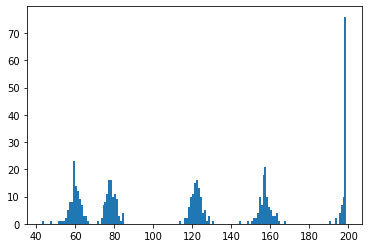

In [112]:
hdata = df12.pred_endlap
plt.hist(hdata, bins=range(min(hdata),max(hdata)+1))

In [130]:
print('pitstops:', set(df12.startlap.values))
pit94 = df12[df12['startlap']==93]
observed = pit94[['endlap','endrank']].values


pitstops: {128, 170, 49, 93, 31}


In [132]:
print(observed[0])

[128.   1.]


In [138]:
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    #plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

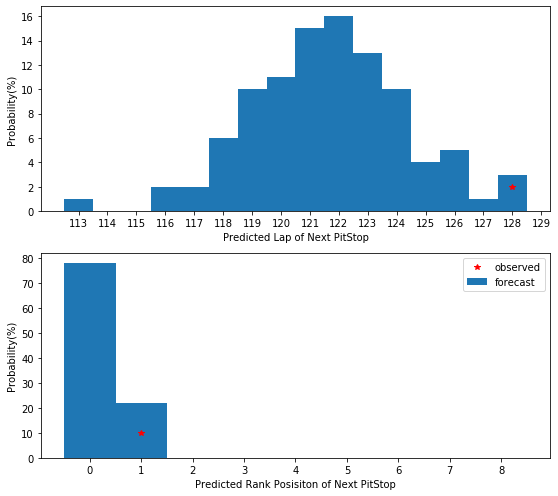

In [181]:
#fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram
fig, axs = plt.subplots(2, 1, figsize=(8, 7))
hdata = pit94.pred_endlap.astype(int)

bins = np.arange(min(hdata),max(hdata))
axs[0].hist(hdata, bins - 0.5, align='mid')
axs[0].set_xticks(bins)
axs[0].plot(observed[0][0],2,'*',color='r')
axs[0].set_xlabel('Predicted Lap of Next PitStop')
axs[0].set_ylabel('Probability(%)')


hdata = pit94.pred_endrank
axs[1].hist(hdata, bins=np.arange(0,10)-0.5,label='forecast')
axs[1].set_xticks(np.arange(0,10))
axs[1].plot(observed[0][1],10,'*',color='r',label='observed')
axs[1].set_xlabel('Predicted Rank Posisiton of Next PitStop')
axs[1].set_ylabel('Probability(%)')

plt.legend(prop={'size': 10})
plt.tight_layout()
plt.savefig('pit94_stint_forecast.pdf')

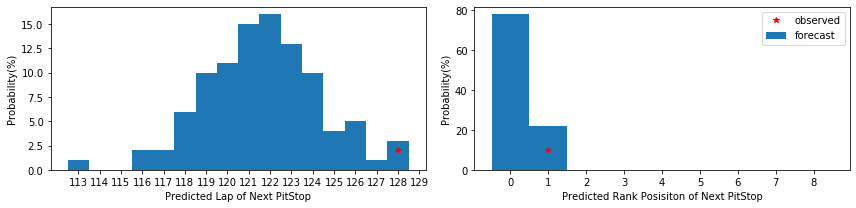

In [186]:
#fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram
fig, axs = plt.subplots(1,2, figsize=(12, 3))
hdata = pit94.pred_endlap.astype(int)

bins = np.arange(min(hdata),max(hdata))
axs[0].hist(hdata, bins - 0.5, align='mid')
axs[0].set_xticks(bins)
axs[0].plot(observed[0][0],2,'*',color='r')
axs[0].set_xlabel('Predicted Lap of Next PitStop')
axs[0].set_ylabel('Probability(%)')


hdata = pit94.pred_endrank
axs[1].hist(hdata, bins=np.arange(0,10)-0.5,label='forecast')
axs[1].set_xticks(np.arange(0,10))
axs[1].plot(observed[0][1],10,'*',color='r',label='observed')
axs[1].set_xlabel('Predicted Rank Posisiton of Next PitStop')
axs[1].set_ylabel('Probability(%)')

plt.legend(prop={'size': 10})
plt.tight_layout()
plt.savefig('pit94_stint_forecast_h.pdf')

In [161]:
np.arange(11)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [149]:
bins

range(113, 131)

(array([78., 22.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

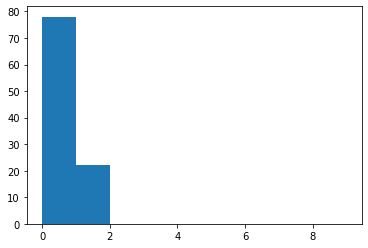

In [123]:
hdata = pit94.pred_endrank
plt.hist(hdata, bins=range(0,10))

In [120]:
pit94.head(2)

,,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
0,89,12,93,0.0,1.0,1.0,1,0.0,0.0,0,128,124
1,89,12,93,0.0,1.0,1.0,1,0.0,0.0,0,128,125


### test

In [ ]:
for year in [2018,2019]:
    fsamples, ftss = runs2samples(ranknet_ret[f'oracle-TIMEDIFF-{year}-noinlap-nopitage'],errlist[f'{year}'])
    _ = prisk_direct_bysamples(fsamples, ftss)
for year in [2018,2019]:
    fsamples, ftss = runs2samples(ranknet_ret[f'pitmodel-TIMEDIFF-{year}-noinlap-nopitage'],errlist[f'{year}'])
    _ = prisk_direct_bysamples(fsamples, ftss)    

In [46]:
for year in ['2018','2019']:
    eval_bydf(ranknetdf[year]['oracle_mean'], ranknetdf[year]['pitmodel_mean'],force2int=True)
    
    eval_bydf(ranknetdf[year]['pitmodel_mean'],ranknetdf[year]['oracle_mean'], force2int=True)


df size: 189
model: acc={0.72}, mae={3.23}, rmse={4.82},r2={-0.53}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
df size: 189
model: acc={0.67}, mae={3.80}, rmse={5.47},r2={-1.91}, {189}
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
df size: 215
model: acc={0.66}, mae={3.57}, rmse={5.39},r2={-0.25}, {215}
            naive: acc={0.16}, mae={4.26}, rmse={6.46},r2={0.43}
df size: 215
model: acc={0.61}, mae={4.32}, rmse={6.16},r2={-1.12}, {215}
            naive: acc={0.16}, mae={4.26}, rmse={6.46},r2={0.43}


In [26]:
for year in ['2018','2019']:
    for clf in ['rf','xgb','svr_lin']:
        #eval_bydf(ranknetdf['2018']['pitmodel_mean'], preddf['2018']['lasso'],force2int=True)
        #eval_bydf(preddf['2018']['lasso'],ranknetdf['2018']['pitmodel_mean'])
        print('year:',year,'clf:',clf)
        eval_bydf(ranknetdf[year]['oracle_mean'], preddf[year][clf],force2int=True)
        eval_bydf(preddf[year][clf],ranknetdf[year]['oracle_mean'])

year: 2018 clf: rf
df size: 185
model: acc={0.71}, mae={3.28}, rmse={4.86},r2={-0.54}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}
df size: 185
model: acc={0.62}, mae={3.38}, rmse={4.56},r2={-1.73}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}
year: 2018 clf: xgb
df size: 185
model: acc={0.71}, mae={3.28}, rmse={4.86},r2={-0.54}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}
df size: 185
model: acc={0.58}, mae={3.57}, rmse={4.78},r2={-0.47}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}
year: 2018 clf: svr_lin
df size: 185
model: acc={0.71}, mae={3.28}, rmse={4.86},r2={-0.54}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}
df size: 185
model: acc={0.62}, mae={3.46}, rmse={4.82},r2={-1.59}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}
year: 2019 clf: rf
df size: 211
model: acc={0.66}, mae={3.62}, rmse={5.44},r2={-0.24}, {211}
          

In [28]:
df = eval_bydf(ranknetdf['2018']['pitmodel_mean'], preddf['2018']['lasso'],force2int=True)

df size: 185
model: acc={0.68}, mae={3.83}, rmse={5.52},r2={-1.90}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


In [29]:
stint.get_evalret(df)

model: acc={0.68}, mae={3.83}, rmse={5.52},r2={-1.90}, {185}
            naive: acc={0.10}, mae={4.15}, rmse={5.55},r2={0.57}


array([[ 0.68108108,  3.83243243,  5.51704974, -1.89966876],
       [ 0.0972973 ,  4.14594595,  5.54928776,  0.57172654]])

In [95]:
eval_bydf(preddf['2018']['lasso'],ranknetdf['2018']['pitmodel_mean'])

df size: 172
model: acc={0.67}, mae={3.33}, rmse={4.43},r2={-1.32}, 
            naive: acc={0.10}, mae={4.23}, rmse={5.51},r2={0.56}


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,1,31,2,2,0,0,6,4,1
1,1,49,2,8,6,1,5,3,1
2,1,69,8,8,0,0,7,-1,-1
3,1,100,8,7,-1,-1,8,0,0
4,1,134,7,16,9,1,7,0,0
...,...,...,...,...,...,...,...,...,...
184,98,31,6,9,3,1,11,5,1
185,98,49,9,14,5,1,8,-1,-1
186,98,91,14,9,-5,-1,12,-2,-1
187,98,124,9,13,4,1,7,-2,-1


In [42]:
eval_bydf(ranknetdf['2018']['pitmodel_mean'], preddf['2018']['lasso'],force2int=True)

df size: 185
model: acc={0.66}, mae={3.82}, rmse={5.45},r2={-6.57}, 
            naive: acc={0.10}, mae={4.29}, rmse={5.75},r2={0.53}


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
0,1,100,8,7,-1,-1,6,-1,-1,134,128
1,1,69,8,8,0,0,5,-2,-1,100,101
2,1,134,7,16,9,1,6,0,-1,169,166
3,1,169,16,7,-9,-1,14,-1,-1,199,199
4,1,49,2,8,6,1,1,0,-1,69,78
...,...,...,...,...,...,...,...,...,...,...,...
180,98,169,13,11,-2,-1,10,-2,-1,199,199
181,98,49,9,14,5,1,8,0,-1,91,79
182,98,91,14,9,-5,-1,11,-2,-1,124,116
183,98,124,9,13,4,1,5,-3,-1,169,150


In [41]:
eval_bydf(preddf['2018']['lasso'],ranknetdf['2018']['pitmodel_mean'])

df size: 185
model: acc={0.66}, mae={3.34}, rmse={4.56},r2={-1.48}, 
            naive: acc={0.10}, mae={4.16}, rmse={5.56},r2={0.56}


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
3,1,100,8,7,-1,-1,8,0,0
2,1,69,8,8,0,0,7,-1,-1
4,1,134,7,16,9,1,7,0,0
5,1,169,16,7,-9,-1,11,-5,-1
1,1,49,2,8,6,1,5,3,1
...,...,...,...,...,...,...,...,...,...
188,98,169,13,11,-2,-1,11,-2,-1
185,98,49,9,14,5,1,8,-1,-1
186,98,91,14,9,-5,-1,12,-2,-1
187,98,124,9,13,4,1,7,-2,-1


In [36]:
eval_bydf(ranknetdf['2019']['pitmodel_mean'], preddf['2019']['lasso'])

df size: 213
model: acc={0.51}, mae={3.98}, rmse={6.03},r2={-2.18}, 
            naive: acc={0.17}, mae={4.17}, rmse={6.38},r2={0.44}


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
0,2.0,65.0,18.0,17.0,-1.0,-1.0,8.40,-9.60,-1.0,101.0,91.0
1,2.0,33.0,27.0,18.0,-9.0,-1.0,9.80,-17.20,-1.0,65.0,66.0
2,2.0,101.0,17.0,13.0,-4.0,-1.0,6.52,-10.48,-1.0,134.0,127.0
3,2.0,134.0,13.0,8.0,-5.0,-1.0,6.07,-6.93,-1.0,170.0,163.0
4,2.0,170.0,8.0,4.0,-4.0,-1.0,2.54,-5.46,-1.0,179.0,196.0
...,...,...,...,...,...,...,...,...,...,...,...
216,98.0,176.0,25.0,25.0,0.0,0.0,24.73,-0.27,-1.0,178.0,194.0
218,98.0,178.0,25.0,25.0,0.0,0.0,25.00,0.00,0.0,180.0,194.0
219,98.0,179.0,25.0,25.0,0.0,0.0,25.00,0.00,0.0,180.0,194.0
220,98.0,180.0,25.0,25.0,0.0,0.0,25.00,0.00,0.0,194.0,194.0


In [92]:
eval_bydf(ranknetdf['2019']['pitmodel_mean'], preddf['2019']['lasso'],force2int=True)

df size: 201
model: acc={0.51}, mae={3.86}, rmse={5.97},r2={-2.69}, 
            naive: acc={0.16}, mae={4.22}, rmse={6.41},r2={0.45}


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
1,2,33,27,18,-9,-1,9,-17,-1,65,66
0,2,65,18,17,-1,-1,8,-9,-1,101,91
2,2,101,17,13,-4,-1,6,-10,-1,134,127
3,2,134,13,8,-5,-1,6,-6,-1,170,163
4,2,170,8,4,-4,-1,2,-5,-1,179,196
...,...,...,...,...,...,...,...,...,...,...,...
194,98,169,29,29,0,0,21,-7,-1,174,194
196,98,176,25,25,0,0,24,0,-1,178,194
197,98,178,25,25,0,0,25,0,0,180,194
198,98,179,25,25,0,0,25,0,0,180,194


In [91]:
eval_bydf(preddf['2019']['lasso'],ranknetdf['2019']['pitmodel_mean'])

df size: 201
model: acc={0.57}, mae={3.99}, rmse={5.45},r2={-1.36}, 
            naive: acc={0.16}, mae={4.22}, rmse={6.41},r2={0.45}


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,2,33,27,18,-9,-1,15,-12,-1
1,2,65,18,17,-1,-1,14,-4,-1
2,2,101,17,13,-4,-1,12,-5,-1
3,2,134,13,8,-5,-1,10,-3,-1
4,2,170,8,4,-4,-1,10,2,1
...,...,...,...,...,...,...,...,...,...
210,98,169,29,29,0,0,28,-1,-1
212,98,176,25,25,0,0,26,1,1
213,98,178,25,25,0,0,25,0,0
214,98,179,25,25,0,0,25,0,0


In [89]:
df1= eval_bydf(ranknetdf['2019']['pitmodel_mean'], preddf['2019']['lasso'],force2int=True)

df size: 201
model: acc={0.51}, mae={3.86}, rmse={5.97},r2={-2.69}, 
            naive: acc={0.16}, mae={4.22}, rmse={6.41},r2={0.45}


In [90]:
df2=eval_bydf(preddf['2019']['lasso'],ranknetdf['2019']['pitmodel_mean'])

df size: 201
model: acc={0.57}, mae={3.99}, rmse={5.45},r2={-1.36}, 
            naive: acc={0.16}, mae={4.22}, rmse={6.41},r2={0.45}


In [39]:
stint.get_evalret(preddf['2019']['lasso'])

model: acc={0.57}, mae={4.03}, rmse={5.45},r2={-1.33}, 
            naive: acc={0.15}, mae={4.29}, rmse={6.46},r2={0.44}


array([[ 0.56944444,  4.02777778,  5.4526582 , -1.32859663],
       [ 0.15277778,  4.29166667,  6.46034915,  0.44268267]])

In [82]:
a = df1['diff'].values
b = df2['diff'].values
a==b

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [84]:
a = df1['startrank'].values
b = df2['startrank'].values
np.where(a!=b)

(array([], dtype=int64),)

In [85]:
a = df1['endrank'].values
b = df2['endrank'].values
np.where(a!=b)

(array([ 34,  60,  61,  62,  91, 180, 187, 188]),)

In [86]:
df1.head(35)


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
1,2,33,27,18,-9,-1,9,-17,-1,65,66
0,2,65,18,17,-1,-1,8,-9,-1,101,91
2,2,101,17,13,-4,-1,6,-10,-1,134,127
3,2,134,13,8,-5,-1,6,-6,-1,170,163
4,2,170,8,4,-4,-1,2,-5,-1,179,196
5,2,179,4,3,-1,-1,1,-2,-1,199,199
6,3,35,7,29,22,1,6,0,-1,40,66
8,3,40,29,27,-2,-1,26,-2,-1,68,70
7,3,68,27,27,0,0,26,0,-1,75,98
9,3,75,27,26,-1,-1,27,0,1,109,104


In [87]:
df2.head(35)

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,2,33,27,18,-9,-1,15,-12,-1
1,2,65,18,17,-1,-1,14,-4,-1
2,2,101,17,13,-4,-1,12,-5,-1
3,2,134,13,8,-5,-1,10,-3,-1
4,2,170,8,4,-4,-1,10,2,1
5,2,179,4,3,-1,-1,5,1,1
6,3,35,7,29,22,1,13,6,1
7,3,40,29,27,-2,-1,20,-9,-1
8,3,68,27,27,0,0,27,0,0
9,3,75,27,26,-1,-1,21,-6,-1


### shortterm test results

In [61]:
outfile=f'shortterm-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-rerank-t{_trim}.pickle'
shortterm_df = load_dfout(outfile)

In [62]:
dfout = shortterm_df['2018']
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    stint.get_evalret_shortterm(df)

model: currank
model: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}, {188}
            naive: acc={0.72}, mae={1.36}, rmse={3.25},r2={0.85}
model: avgrank
model: acc={0.64}, mae={2.04}, rmse={3.59},r2={0.82}, {188}
            naive: acc={0.72}, mae={1.36}, rmse={3.25},r2={0.85}
model: dice
model: acc={0.45}, mae={2.21}, rmse={4.01},r2={0.78}, {188}
            naive: acc={0.72}, mae={1.36}, rmse={3.25},r2={0.85}
model: lasso
model: acc={0.73}, mae={1.41}, rmse={3.22},r2={0.85}, {188}
            naive: acc={0.72}, mae={1.36}, rmse={3.25},r2={0.85}
model: ridge
model: acc={0.73}, mae={1.42}, rmse={3.22},r2={0.85}, {188}
            naive: acc={0.72}, mae={1.36}, rmse={3.25},r2={0.85}
model: rf
model: acc={0.51}, mae={1.75}, rmse={3.34},r2={0.84}, {188}
            naive: acc={0.72}, mae={1.36}, rmse={3.25},r2={0.85}
model: svr
model: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}, {188}
            naive: acc={0.72}, mae={1.36}, rmse={3.25},r2={0.85}
model: xgb
model: acc={0.46}, mae={1

In [66]:
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    fsamples, ftss = df2samples(shortterm_df['2018'][clf])
    _ = prisk_direct_bysamples(fsamples, ftss)

model: currank


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.09733723382543032, 0.0973263487312062, 0.0973154636369821])
model: avgrank
dict_values([0.1483611130008844, 0.1483502279066603, 0.14833934281243624])
model: dice
dict_values([0.1598993128784271, 0.159888427784203, 0.1598775426899789])
model: lasso
dict_values([0.10250765358187632, 0.10249676848765223, 0.10248588339342812])
model: ridge
dict_values([0.10299748282196067, 0.10298659772773658, 0.10297571263351249])
model: rf
dict_values([0.12656371181713044, 0.12655282672290633, 0.1265419416286822])
model: svr
dict_values([0.09733723382543032, 0.0973263487312062, 0.0973154636369821])
model: xgb
dict_values([0.11848152935573845, 0.1184706442615144, 0.11845975916729033])


In [56]:
dfout = shortterm_df['2019']
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    stint.get_evalret_shortterm(df)

model: currank
model: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}, {188}
            naive: acc={0.73}, mae={1.18}, rmse={3.07},r2={0.88}
model: avgrank
model: acc={0.60}, mae={1.81}, rmse={3.36},r2={0.85}, {188}
            naive: acc={0.73}, mae={1.18}, rmse={3.07},r2={0.88}
model: dice
model: acc={0.49}, mae={2.06}, rmse={3.83},r2={0.81}, {188}
            naive: acc={0.73}, mae={1.18}, rmse={3.07},r2={0.88}
model: lasso
model: acc={0.74}, mae={1.24}, rmse={3.04},r2={0.88}, {188}
            naive: acc={0.73}, mae={1.18}, rmse={3.07},r2={0.88}
model: ridge
model: acc={0.74}, mae={1.24}, rmse={3.04},r2={0.88}, {188}
            naive: acc={0.73}, mae={1.18}, rmse={3.07},r2={0.88}
model: rf
model: acc={0.62}, mae={1.33}, rmse={2.88},r2={0.89}, {188}
            naive: acc={0.73}, mae={1.18}, rmse={3.07},r2={0.88}
model: svr
model: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}, {188}
            naive: acc={0.73}, mae={1.18}, rmse={3.07},r2={0.88}
model: xgb
model: acc={0.64}, mae={1

In [67]:
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    fsamples, ftss = df2samples(shortterm_df['2019'][clf])
    _ = prisk_direct_bysamples(fsamples, ftss)

model: currank


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.080397193103194, 0.08039719310319401, 0.08039719310319403])
model: avgrank
dict_values([0.12510599599365868, 0.12510599599365868, 0.12510599599365868])
model: dice
dict_values([0.14253235182067317, 0.14253235182067323, 0.14253235182067325])
model: lasso
dict_values([0.08563247348563986, 0.08563247348563985, 0.08563247348563983])
model: ridge
dict_values([0.08560789470450161, 0.0856078947045016, 0.08560789470450159])
model: rf
dict_values([0.09204753536272138, 0.09204753536272137, 0.09204753536272137])
model: svr
dict_values([0.080397193103194, 0.08039719310319401, 0.08039719310319403])
model: xgb
dict_values([0.08622236423295768, 0.08622236423295769, 0.08622236423295769])


In [24]:
np.sum(df['diff'].values == 0)/len(df)

0.5906367041198501

In [22]:
outfile=f'shortterm-dfout-ranknet-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}.pickle'
sranknet_df = load_dfout(outfile)

In [23]:
sranknet_df.keys()

dict_keys(['2018', '2019'])

In [17]:
sranknet_df['2018']['oracle-TIMEDIFF-2018-inlap-nopitage']

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,1,10,3.0,3.0,0.0,0,3.0,0.0,0
1,3,10,7.0,7.0,0.0,0,7.0,0.0,0
2,4,10,12.0,12.0,0.0,0,12.0,0.0,0
3,6,10,15.0,15.0,0.0,0,15.0,0.0,0
4,7,10,28.0,28.0,0.0,0,28.0,0.0,0
...,...,...,...,...,...,...,...,...,...
5335,60,197,15.0,15.0,0.0,0,16.0,1.0,1
5336,64,197,16.0,16.0,0.0,0,14.0,-2.0,-1
5337,66,197,10.0,10.0,0.0,0,10.0,0.0,0
5338,88,197,13.0,13.0,0.0,0,13.0,0.0,0


In [34]:
dfout = sranknet_df['2018']
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    stint.get_evalret_shortterm(df)

model: oracle-TIMEDIFF-2018-inlap-nopitage
model: acc={0.84}, mae={0.89}, rmse={2.13},r2={0.94}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}


In [24]:
dfout = sranknet_df['2019']
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    stint.get_evalret_shortterm(df)

model: oracle-TIMEDIFF-2019-inlap-nopitage
model: acc={0.81}, mae={0.84}, rmse={2.11},r2={0.94}, {188}
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}


In [19]:
dfx = sranknet_df['2018']['oracle-TIMEDIFF-2018-inlap-nopitage']

In [23]:
np.sum(dfx['diff'].values == 0)/len(dfx)

0.5906367041198501

In [35]:
dfout = sranknet_df['2019']
for clf in dfout:
    df = dfout[clf]
    print('model:', clf)
    stint.get_evalret_shortterm(df)

model: oracle-TIMEDIFF-2019-inlap-nopitage
model: acc={0.81}, mae={0.84}, rmse={2.11},r2={0.94}, {188}
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}


In [63]:
df = shortterm_df['2018']['lasso']
df[df['carno']==12].head(40)

,carno,startlap,startrank,endrank,pred_endrank,diff,sign,pred_diff,pred_sign
7,12.0,9.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
40,12.0,10.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
73,12.0,11.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
106,12.0,12.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
139,12.0,13.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
172,12.0,14.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
205,12.0,15.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
238,12.0,16.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
271,12.0,17.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
304,12.0,18.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0


In [61]:
np.sum(df.sign ==df.pred_sign)/len(df)

0.5820224719101124

In [25]:
outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-usemean.pickle'
ranknet_mlp = load_dfout(outfile)

In [26]:
df_ranknet_mlp_2018 = ranknet_mlp['2018']['pitmodel_mean']

In [27]:
df_ranknet_mlp_2018

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,1.0,10.0,3.0,3.0,0.0,0.0,3.00,0.00,0.0
1,1.0,11.0,3.0,3.0,0.0,0.0,3.00,0.00,0.0
2,1.0,12.0,3.0,3.0,0.0,0.0,3.00,0.00,0.0
3,1.0,13.0,3.0,3.0,0.0,0.0,3.00,0.00,0.0
4,1.0,14.0,3.0,3.0,0.0,0.0,3.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...
5335,98.0,193.0,15.0,13.0,-2.0,-1.0,15.02,0.02,1.0
5336,98.0,194.0,15.0,11.0,-4.0,-1.0,14.99,-0.01,-1.0
5337,98.0,195.0,13.0,11.0,-2.0,-1.0,12.98,-0.02,-1.0
5338,98.0,196.0,11.0,11.0,0.0,0.0,10.97,-0.03,-1.0


In [38]:
df = do_rerank(df_ranknet_mlp_2018)
df

rerank...


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,1,10,3,3,0,0,3,0,0
1,3,10,7,7,0,0,7,0,0
2,4,10,12,12,0,0,12,0,0
3,6,10,15,15,0,0,15,0,0
4,7,10,28,28,0,0,28,0,0
...,...,...,...,...,...,...,...,...,...
5335,60,197,15,15,0,0,15,0,0
5336,64,197,16,16,0,0,16,0,0
5337,66,197,10,10,0,0,10,0,0
5338,88,197,13,13,0,0,13,0,0


In [39]:
stint.get_evalret_shortterm(df)

model: acc={0.78}, mae={1.21}, rmse={2.87},r2={0.88}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}


array([[0.78191489, 1.21385768, 2.87009637, 0.88499164],
       [0.71808511, 1.33932584, 3.24896987, 0.85262365]])

In [58]:
fsamples, ftss = df2samples(df_ranknet_mlp_2018)
prisk_direct_bysamples(fsamples, ftss)
fsamples, ftss = df2samples(df)
prisk_direct_bysamples(fsamples, ftss)

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.08749216470333948, 0.08749216470333947, 0.08749216470333945])
dict_values([0.17447811447811445, 0.8481481481481481, 1.5218181818181822])


({'wQuantileLoss[0.1]': 0.17447811447811445,
  'wQuantileLoss[0.5]': 0.8481481481481481,
  'wQuantileLoss[0.9]': 1.5218181818181822},
 array([[  9. ,  45. ,  81. ],
        [ 13.2,  34. ,  54.8],
        [ 11.6,  58. , 104.4],
        [ 15.6,  78. , 140.4],
        [ 49.8, 249. , 448.2],
        [  5.2,  26. ,  46.8],
        [  7.6,  38. ,  68.4],
        [  9.8,  17. ,  24.2],
        [  2.8,  14. ,  25.2],
        [ 15.6,  78. , 140.4],
        [ 11.6,  58. , 104.4],
        [ 41. , 205. , 369. ],
        [  4.8,  24. ,  43.2],
        [ 14.2,  71. , 127.8],
        [  2.4,  12. ,  21.6],
        [ 32.6, 163. , 293.4],
        [  2.2,  11. ,  19.8],
        [ 23. , 115. , 207. ],
        [  9. ,  45. ,  81. ],
        [ 19.4,  97. , 174.6],
        [ 23.8, 119. , 214.2],
        [  8.4,  42. ,  75.6],
        [  7.2,  28. ,  48.8],
        [ 11.4,  57. , 102.6],
        [  2.8,  14. ,  25.2],
        [ 20. , 100. , 180. ],
        [  5.4,  27. ,  48.6],
        [ 45.8, 229. , 412.2]

In [40]:
df_ranknet_mlp_2019 = do_rerank(ranknet_mlp['2019']['pitmodel_mean'])

rerank...


In [42]:
df_ranknet_mlp_2019

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,2,10,4,4,0,0,4,0,0
1,3,10,11,11,0,0,11,0,0
2,4,10,21,21,0,0,21,0,0
3,5,10,25,25,0,0,25,0,0
4,7,10,12,12,0,0,12,0,0
...,...,...,...,...,...,...,...,...,...
5624,28,197,6,7,1,1,6,-1,-1
5625,30,197,2,2,0,0,2,0,0
5626,33,197,11,11,0,0,11,0,0
5627,39,197,15,15,0,0,15,0,0


In [41]:
stint.get_evalret_shortterm(df_ranknet_mlp_2019)

model: acc={0.78}, mae={1.07}, rmse={2.74},r2={0.90}, {188}
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}


array([[0.77659574, 1.07408065, 2.73914791, 0.90201302],
       [0.73404255, 1.16255107, 3.05012312, 0.87850116]])

In [234]:
#
# Model,SignAcc,MAE,50-Risk,90-Risk
# 
cols = ['Year','Model','SignAcc','MAE','50-Risk','90-Risk']
models = {'currank':'CurRank','rf':'RandomForest','svr':'SVM','xgb':'XGBoost'}
#plen=2
#usemeanstr='median'
usemeanstr='mean'
stint_result = {}

In [240]:
#for plen in [2,4,6,8]:
#for plen in [2,4,6]:
for plen in [8]:
    outfile=f'shortterm-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-rerank-t{plen}.pickle'
    shortterm_df = load_dfout(outfile)
    outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-{usemeanstr}-t{plen}-alldata.pickle'
    _all = load_dfout_all(outfile)[0]
    ranknetdf, ranknet_acc, ranknet_ret,ranknet_pret = _all[0],_all[1],_all[2],_all[3]

    retdata = []
    for year in ['2018','2019']:
        for clf in ['currank','rf','svr','xgb']:
            print('year:',year,'clf:',clf)
            #dfout, accret = eval_sync(preddf[year][clf],errlist[year])
            dfout = shortterm_df[year][clf]
            accret = stint.get_evalret_shortterm(dfout)[0]

            fsamples, ftss = df2samples(dfout)
            _, prisk_vals = prisk_direct_bysamples(fsamples, ftss)

            retdata.append([year,models[clf],accret[0], accret[1], prisk_vals[1], prisk_vals[2]])

        #oracle
        dfout = do_rerank(ranknetdf[year]['oracle_mean'])
        accret = stint.get_evalret_shortterm(dfout)[0]
        fsamples, ftss = runs2samples_ex(ranknet_ret[f'oracle-RANK-{year}-inlap-nopitage'],[])
        _, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
        retdata.append([year,'RankNet-Oracle',accret[0], accret[1], prisk_vals[1], prisk_vals[2]])
        
        raw_prisk = ranknet_pret[f'oracle-RANK-{year}-inlap-nopitage']
        retdata.append([year,'RankNet-Oracle',accret[0], accret[1], raw_prisk[1], raw_prisk[2]])

        #pitmodel
        dfout = do_rerank(ranknetdf[year]['pitmodel_mean'])
        accret = stint.get_evalret_shortterm(dfout)[0]
        fsamples, ftss = runs2samples_ex(ranknet_ret[f'pitmodel-RANK-{year}-inlap-nopitage'],[])
        _, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
        retdata.append([year,'RankNet-MLP',accret[0], accret[1], prisk_vals[1], prisk_vals[2]])

        raw_prisk = ranknet_pret[f'pitmodel-RANK-{year}-inlap-nopitage']
        retdata.append([year,'RankNet-MLP',accret[0], accret[1], raw_prisk[1], raw_prisk[2]])

        #print('oracle:', ranknet_pret[f'oracle-RANK-2018-inlap-nopitage'])
        #print('pitmodel:', ranknet_pret[f'pitmodel-RANK-2018-inlap-nopitage'])

    stint_result[plen] = pd.DataFrame(data=retdata, columns=cols)
    
    print(stint_result[plen])


year: 2018 clf: currank
model: acc={0.47}, mae={3.53}, rmse={5.70},r2={0.54}, {182}
            naive: acc={0.47}, mae={3.61}, rmse={5.73},r2={0.55}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.2582194605201416, 0.2582080850882307, 0.2581967096563198])
year: 2018 clf: rf
model: acc={0.43}, mae={3.23}, rmse={5.02},r2={0.64}, {182}
            naive: acc={0.47}, mae={3.61}, rmse={5.73},r2={0.55}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.23626487693204606, 0.23625350150013508, 0.23624212606822417])
year: 2018 clf: svr
model: acc={0.52}, mae={3.50}, rmse={5.65},r2={0.55}, {182}
            naive: acc={0.47}, mae={3.61}, rmse={5.73},r2={0.55}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.2560296898772875, 0.2560183144453766, 0.25600693901346566])
year: 2018 clf: xgb
model: acc={0.41}, mae={3.23}, rmse={5.04},r2={0.64}, {182}
            naive: acc={0.47}, mae={3.61}, rmse={5.73},r2={0.55}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.23598049113427275, 0.23596911570236181, 0.23595774027045086])
rerank...
model: acc={0.59}, mae={3.29}, rmse={5.29},r2={0.59}, {182}
            naive: acc={0.47}, mae={3.51}, rmse={5.66},r2={0.53}
run2samples_ex, samplecnt: 100


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.21718112731433942, 0.2448505032129339, 0.2098849799008245])
rerank...
model: acc={0.64}, mae={3.13}, rmse={5.09},r2={0.62}, {182}
            naive: acc={0.47}, mae={3.51}, rmse={5.66},r2={0.53}
run2samples_ex, samplecnt: 10


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.21725829641149028, 0.23342918341597957, 0.19943428889997353])
oracle: [0.20276889 0.21057462 0.19098435]
pitmodel: [0.19377433 0.21807219 0.19656207]
year: 2019 clf: currank
model: acc={0.39}, mae={2.69}, rmse={5.00},r2={0.67}, {182}
            naive: acc={0.39}, mae={2.76}, rmse={5.06},r2={0.67}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.18605778429746792, 0.18605778429746794, 0.186057784297468])
year: 2019 clf: rf
model: acc={0.34}, mae={2.73}, rmse={4.47},r2={0.74}, {182}
            naive: acc={0.39}, mae={2.76}, rmse={5.06},r2={0.67}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.18906818036864595, 0.18906818036864595, 0.18906818036864595])
year: 2019 clf: svr
model: acc={0.42}, mae={2.65}, rmse={4.95},r2={0.68}, {182}
            naive: acc={0.39}, mae={2.76}, rmse={5.06},r2={0.67}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.1836851840040819, 0.1836851840040819, 0.18368518400408188])
year: 2019 clf: xgb
model: acc={0.33}, mae={2.62}, rmse={4.37},r2={0.75}, {182}
            naive: acc={0.39}, mae={2.76}, rmse={5.06},r2={0.67}


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.18154219019070097, 0.18154219019070095, 0.1815421901907009])
rerank...
model: acc={0.51}, mae={2.43}, rmse={4.47},r2={0.74}, {182}
            naive: acc={0.39}, mae={2.69}, rmse={5.00},r2={0.67}
run2samples_ex, samplecnt: 100


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


dict_values([0.1406947457605361, 0.16813437913195292, 0.13932605039859303])
rerank...
model: acc={0.53}, mae={2.36}, rmse={4.35},r2={0.75}, {182}
            naive: acc={0.39}, mae={2.69}, rmse={5.00},r2={0.67}
run2samples_ex, samplecnt: 10
dict_values([0.14614025853990423, 0.16390454306217025, 0.1372641497323457])
oracle: [0.20276889 0.21057462 0.19098435]
pitmodel: [0.19377433 0.21807219 0.19656207]
    Year           Model   SignAcc       MAE   50-Risk   90-Risk
0   2018         CurRank  0.467033  3.531505  0.258208  0.258197
1   2018    RandomForest  0.428571  3.234345  0.236254  0.236242
2   2018             SVM  0.516484  3.501556  0.256018  0.256007
3   2018         XGBoost  0.412088  3.230844  0.235969  0.235958
4   2018     RankNet-MLP  0.593407  3.289422  0.244851  0.209885
5   2018  RankNet-Oracle  0.642857  3.132914  0.233429  0.199434
6   2019         CurRank  0.390110  2.686040  0.186058  0.186058
7   2019    RandomForest  0.335165  2.733493  0.189068  0.189068
8   2019  

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


In [238]:
stint_result[2]

,Year,Model,SignAcc,MAE,50-Risk,90-Risk
0,2018,CurRank,0.718085,1.339513,0.097326,0.097315
1,2018,RandomForest,0.473404,1.688951,0.122416,0.122406
2,2018,SVM,0.718085,1.339513,0.097326,0.097315
3,2018,XGBoost,0.462766,1.630899,0.118471,0.118460
4,2018,RankNet-MLP,0.781915,1.308614,0.095631,0.081060
5,2018,RankNet-Oracle,0.845745,1.269663,0.093719,0.077423
6,2019,CurRank,0.734043,1.162551,0.080397,0.080397
7,2019,RandomForest,0.627660,1.317108,0.090941,0.090941
8,2019,SVM,0.734043,1.162551,0.080397,0.080397
9,2019,XGBoost,0.643617,1.247113,0.086222,0.086222


In [236]:
stint_result[4]

,Year,Model,SignAcc,MAE,50-Risk,90-Risk
0,2018,CurRank,0.596774,2.271710,0.165394,0.165383
1,2018,RandomForest,0.473118,2.391923,0.173953,0.173942
2,2018,SVM,0.596774,2.271331,0.165367,0.165356
3,2018,XGBoost,0.516129,2.161737,0.157194,0.157183
4,2018,RankNet-MLP,0.693548,2.110732,0.153382,0.129460
5,2018,RankNet-Oracle,0.752688,2.011756,0.147576,0.123427
6,2019,CurRank,0.575269,1.895777,0.131129,0.131129
7,2019,RandomForest,0.505376,1.970171,0.136205,0.136205
8,2019,SVM,0.575269,1.895777,0.131129,0.131129
9,2019,XGBoost,0.462366,1.703145,0.117668,0.117668


In [237]:
stint_result[6]

,Year,Model,SignAcc,MAE,50-Risk,90-Risk
0,2018,CurRank,0.521739,2.982527,0.217601,0.217590
1,2018,RandomForest,0.467391,2.814708,0.205189,0.205178
2,2018,SVM,0.521739,2.972926,0.216900,0.216889
3,2018,XGBoost,0.396739,2.659562,0.193786,0.193774
4,2018,RankNet-MLP,0.630435,2.617896,0.190097,0.162004
5,2018,RankNet-Oracle,0.717391,2.360215,0.173874,0.148023
6,2019,CurRank,0.472826,2.367570,0.163906,0.163906
7,2019,RandomForest,0.429348,2.346846,0.162319,0.162319
8,2019,SVM,0.494565,2.349755,0.162671,0.162671
9,2019,XGBoost,0.396739,2.151972,0.148790,0.148790


In [241]:
stint_result[8]

,Year,Model,SignAcc,MAE,50-Risk,90-Risk
0,2018,CurRank,0.467033,3.531505,0.258208,0.258197
1,2018,RandomForest,0.428571,3.234345,0.236254,0.236242
2,2018,SVM,0.516484,3.501556,0.256018,0.256007
3,2018,XGBoost,0.412088,3.230844,0.235969,0.235958
4,2018,RankNet-MLP,0.593407,3.289422,0.244851,0.209885
5,2018,RankNet-Oracle,0.642857,3.132914,0.233429,0.199434
6,2019,CurRank,0.390110,2.686040,0.186058,0.186058
7,2019,RandomForest,0.335165,2.733493,0.189068,0.189068
8,2019,SVM,0.423077,2.651830,0.183685,0.183685
9,2019,XGBoost,0.329670,2.624241,0.181542,0.181542


In [227]:
stint_result

,Year,Model,SignAcc,MAE,50-Risk,90-Risk
0,2018,CurRank,0.718085,1.339513,0.097326,0.097315
1,2018,RandomForest,0.521277,1.763109,0.127805,0.127794
2,2018,SVM,0.718085,1.339513,0.097326,0.097315
3,2018,XGBoost,0.462766,1.630899,0.118471,0.118460
4,2018,RankNet-MLP,0.781915,1.308614,0.095631,0.081060
5,2018,RankNet-Oracle,0.845745,1.269663,0.093719,0.077423
6,2019,CurRank,0.734043,1.162551,0.080397,0.080397
7,2019,RandomForest,0.664894,1.314265,0.090819,0.090819
8,2019,SVM,0.734043,1.162551,0.080397,0.080397
9,2019,XGBoost,0.643617,1.247113,0.086222,0.086222


In [242]:
for plen in [2,4,6,8]:

    outfile=f'shortterm-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-rerank-t{plen}.pickle'
    shortterm_df = load_dfout(outfile)
    outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-{usemeanstr}-t{plen}-alldata.pickle'
    _all = load_dfout_all(outfile)[0]
    ranknetdf, ranknet_acc, ranknet_ret,ranknet_pret = _all[0],_all[1],_all[2],_all[3]

    retdata = []
    for year in ['2018','2019']:

        #oracle
        dfout = do_rerank(ranknetdf[year]['oracle_mean'])
        accret = stint.get_evalret_shortterm(dfout)[0]
        raw_prisk = ranknet_pret[f'oracle-RANK-{year}-inlap-nopitage']
        retdata.append([year,'RankNet-Oracle-Raw',accret[0], accret[1], raw_prisk[1], raw_prisk[2]])

        #pitmodel
        dfout = do_rerank(ranknetdf[year]['pitmodel_mean'])
        accret = stint.get_evalret_shortterm(dfout)[0]
        raw_prisk = ranknet_pret[f'pitmodel-RANK-{year}-inlap-nopitage']
        retdata.append([year,'RankNet-MLP-Raw',accret[0], accret[1], raw_prisk[1], raw_prisk[2]])
        
    dfx = pd.DataFrame(data=retdata, columns=cols)
    stint_result[plen] = pd.concat([stint_result[plen],dfx])

rerank...
model: acc={0.85}, mae={1.27}, rmse={3.01},r2={0.87}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
rerank...
model: acc={0.78}, mae={1.31}, rmse={3.09},r2={0.87}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
rerank...
model: acc={0.86}, mae={1.11}, rmse={2.83},r2={0.90}, {188}
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}
rerank...
model: acc={0.79}, mae={1.15}, rmse={2.93},r2={0.89}, {188}
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}
rerank...
model: acc={0.75}, mae={2.01}, rmse={3.86},r2={0.79}, {186}
            naive: acc={0.60}, mae={2.27}, rmse={4.44},r2={0.72}
rerank...
model: acc={0.69}, mae={2.11}, rmse={4.04},r2={0.77}, {186}
            naive: acc={0.60}, mae={2.27}, rmse={4.44},r2={0.72}
rerank...
model: acc={0.75}, mae={1.66}, rmse={3.55},r2={0.84}, {186}
            naive: acc={0.58}, mae={1.90}, rmse={4.12},r2={0.78}
rerank...
model: acc={0.67}, mae={1.73}, rmse={3.69},r2

In [263]:
stint_result[2]

,Year,Model,SignAcc,MAE,50-Risk,90-Risk,plen
0,2018,CurRank,0.718085,1.339513,0.097326,0.097315,2
1,2018,RandomForest,0.473404,1.688951,0.122416,0.122406,2
2,2018,SVM,0.718085,1.339513,0.097326,0.097315,2
3,2018,XGBoost,0.462766,1.630899,0.118471,0.118460,2
4,2018,RankNet-MLP,0.781915,1.308614,0.095631,0.081060,2
5,2018,RankNet-Oracle,0.845745,1.269663,0.093719,0.077423,2
6,2019,CurRank,0.734043,1.162551,0.080397,0.080397,2
7,2019,RandomForest,0.627660,1.317108,0.090941,0.090941,2
8,2019,SVM,0.734043,1.162551,0.080397,0.080397,2
9,2019,XGBoost,0.643617,1.247113,0.086222,0.086222,2


In [247]:
dfs = []
for plen in stint_result:
    df = stint_result[plen]
    df['plen'] = plen
    
    dfs.append(df)
    
alldf = pd.concat(dfs)
    

In [249]:
alldf

,Year,Model,SignAcc,MAE,50-Risk,90-Risk,plen
0,2018,CurRank,0.718085,1.339513,0.097326,0.097315,2
1,2018,RandomForest,0.473404,1.688951,0.122416,0.122406,2
2,2018,SVM,0.718085,1.339513,0.097326,0.097315,2
3,2018,XGBoost,0.462766,1.630899,0.118471,0.118460,2
4,2018,RankNet-MLP,0.781915,1.308614,0.095631,0.081060,2
...,...,...,...,...,...,...,...
11,2019,RankNet-Oracle,0.527473,2.361596,0.163905,0.137264,8
0,2018,RankNet-Oracle-Raw,0.642857,3.132914,0.210575,0.190984,8
1,2018,RankNet-MLP-Raw,0.593407,3.289422,0.218072,0.196562,8
2,2019,RankNet-Oracle-Raw,0.527473,2.361596,0.149313,0.133963,8


In [251]:
alldf.to_csv('evaluation_result_shortterm_plen2-8_all.csv')

### check the plen2 variance

In [255]:
outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-alldata.pickle'
_all = load_dfout_all(outfile)[0]
ranknetdf, acc, ret = _all[0],_all[1],_all[2]

In [256]:
allsamples, alltss = get_allsamples(year=2018, model='pitmodel')
prisk_direct_bysamples(allsamples, alltss)

sacmplecnt: 100 lapcnt: 200 runcnt: 100


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: Mean of empty slice


dict_values([0.06751312547281964, 0.08580771101264455, 0.0768863071436291])


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


({'wQuantileLoss[0.1]': 0.06751312547281964,
  'wQuantileLoss[0.5]': 0.08580771101264455,
  'wQuantileLoss[0.9]': 0.0768863071436291},
 array([0.06751313, 0.08580771, 0.07688631]))

In [257]:
allsamples, alltss = get_allsamples(year=2019, model='pitmodel')
prisk_direct_bysamples(allsamples, alltss)

sacmplecnt: 100 lapcnt: 200 runcnt: 100


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: Mean of empty slice


dict_values([0.0560034299534611, 0.07171949625612273, 0.060852226171717545])


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


({'wQuantileLoss[0.1]': 0.0560034299534611,
  'wQuantileLoss[0.5]': 0.07171949625612273,
  'wQuantileLoss[0.9]': 0.060852226171717545},
 array([0.05600343, 0.0717195 , 0.06085223]))

In [258]:
outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-oracle.pickle'
_all = load_dfout_all(outfile)[0]
ranknetdf, acc, ret = _all[0],_all[1],_all[2]

KeyError: 0

In [260]:
outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-oracle-alldata.pickle'
_all = load_dfout_all(outfile)[0]
ranknetdf, acc, ret, pret = _all[0],_all[1],_all[2],_all[3]

In [261]:
pret

{'oracle-RANK-2019-inlap-nopitage': array([0.04074804, 0.0664126 , 0.03118937]),
 'oracle-RANK-2018-inlap-nopitage': array([0.0496801 , 0.07956203, 0.03740165])}

In [262]:
allsamples, alltss = get_allsamples(year=2019, model='oracle')
prisk_direct_bysamples(allsamples, alltss)

sacmplecnt: 100 lapcnt: 200 runcnt: 1
dict_values([0.06700013436427377, 0.06700013436427378, 0.06700013436427377])


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: Mean of empty slice
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


({'wQuantileLoss[0.1]': 0.06700013436427377,
  'wQuantileLoss[0.5]': 0.06700013436427378,
  'wQuantileLoss[0.9]': 0.06700013436427377},
 array([0.06700013, 0.06700013, 0.06700013]))

In [ ]:
prisk_direct_bysamples(allsamples, alltss)

In [276]:
outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-oracle-l10-alldata.pickle'
_all = load_dfout_all(outfile)[0]
ranknetdf, acc, ret, pret = _all[0],_all[1],_all[2],_all[3]

for year in ['2018','2019']:
    dfout = do_rerank(ranknetdf[year]['oracle_mean'])
    accret = stint.get_evalret_shortterm(dfout)[0]
    print('year:', year, accret)
    print(pret)

rerank...
model: acc={0.86}, mae={1.11}, rmse={2.67},r2={0.90}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
year: 2018 [0.86170213 1.10898876 2.66697096 0.90069457]
{'oracle-RANK-2019-inlap-nopitage': array([0.06158776, 0.06656809, 0.06055966])}
rerank...
model: acc={0.86}, mae={0.97}, rmse={2.55},r2={0.92}, {188}
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}
year: 2019 [0.85638298 0.97352993 2.54649429 0.91531182]
{'oracle-RANK-2019-inlap-nopitage': array([0.06158776, 0.06656809, 0.06055966])}


In [278]:
#for mid in ret:
for year in [2018,2019]:
    #mid = 'oracle-RANK-2018-inlap-nopitage'
    #pret[mid] = prisk(ret[mid][0][1], ret[mid][0][2])
    allsamples, alltss = get_allsamples(year=year, model='oracle')
    #_, pret[mid]= prisk_direct_bysamples(ret[mid][0][1], ret[mid][0][2])
    prisk_direct_bysamples(allsamples, alltss)
    

sacmplecnt: 100 lapcnt: 200 runcnt: 10
dict_values([0.07416067221441695, 0.07966321733491842, 0.07335211012644548])
sacmplecnt: 100 lapcnt: 200 runcnt: 10
dict_values([0.06158775575018017, 0.06656809214946192, 0.060559658959043326])


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: Mean of empty slice
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


In [275]:
ret['oracle-RANK-2018-inlap-nopitage'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [279]:
outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-mean-t2-alldata.pickle'
_all = load_dfout_all(outfile)[0]
ranknetdf, acc, ret, pret = _all[0],_all[1],_all[2],_all[3]

for year in ['2018','2019']:
    dfout = do_rerank(ranknetdf[year]['oracle_mean'])
    accret = stint.get_evalret_shortterm(dfout)[0]
    print('year:', year, accret)

rerank...
model: acc={0.85}, mae={1.27}, rmse={3.01},r2={0.87}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
year: 2018 [0.84574468 1.26966292 3.01432286 0.87314255]
rerank...
model: acc={0.86}, mae={1.11}, rmse={2.83},r2={0.90}, {188}
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}
year: 2019 [0.86170213 1.11245337 2.83438772 0.89508057]


In [268]:
ranknetdf['2018']['oracle_mean']

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,1.0,10.0,3.0,3.0,0.0,0.0,3.0,0.0,0.0
1,1.0,11.0,3.0,3.0,0.0,0.0,3.0,0.0,0.0
2,1.0,12.0,3.0,3.0,0.0,0.0,3.0,0.0,0.0
3,1.0,13.0,3.0,3.0,0.0,0.0,3.0,0.0,0.0
4,1.0,14.0,3.0,3.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5335,98.0,193.0,15.0,13.0,-2.0,-1.0,15.0,0.0,0.0
5336,98.0,194.0,15.0,11.0,-4.0,-1.0,15.0,0.0,0.0
5337,98.0,195.0,13.0,11.0,-2.0,-1.0,13.3,0.3,1.0
5338,98.0,196.0,11.0,11.0,0.0,0.0,11.1,0.1,1.0


In [272]:
ret['oracle-RANK-2018-inlap-nopitage'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [280]:
#for mid in ret:
for year in [2018,2019]:
    #mid = 'oracle-RANK-2018-inlap-nopitage'
    #pret[mid] = prisk(ret[mid][0][1], ret[mid][0][2])
    allsamples, alltss = get_allsamples(year=year, model='oracle')
    #_, pret[mid]= prisk_direct_bysamples(ret[mid][0][1], ret[mid][0][2])
    prisk_direct_bysamples(allsamples, alltss)

sacmplecnt: 100 lapcnt: 200 runcnt: 10
dict_values([0.08136107748838216, 0.08675280989949205, 0.07910578190857019])
sacmplecnt: 100 lapcnt: 200 runcnt: 10
dict_values([0.06767095166550625, 0.07268307132299949, 0.06521068806723097])


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: Mean of empty slice
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


In [281]:
outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-oracle-l100-alldata.pickle'
_all = load_dfout_all(outfile)[0]
ranknetdf, acc, ret, pret = _all[0],_all[1],_all[2],_all[3]

for year in ['2018','2019']:
    dfout = do_rerank(ranknetdf[year]['oracle_mean'])
    accret = stint.get_evalret_shortterm(dfout)[0]
    print('year:', year, accret)
    print(pret)
    
    allsamples, alltss = get_allsamples(year=year, model='oracle')
    #_, pret[mid]= prisk_direct_bysamples(ret[mid][0][1], ret[mid][0][2])
    prisk_direct_bysamples(allsamples, alltss)    

rerank...
model: acc={0.87}, mae={1.11}, rmse={2.66},r2={0.90}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
year: 2018 [0.86702128 1.1071161  2.66134769 0.90111289]
{'oracle-RANK-2019-inlap-nopitage': array([0.0607115 , 0.06656638, 0.0593955 ])}
sacmplecnt: 100 lapcnt: 200 runcnt: 100


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: Mean of empty slice
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: Mean of empty slice


dict_values([0.07289022209013293, 0.07944517994164053, 0.07194797903382688])
rerank...
model: acc={0.85}, mae={0.98}, rmse={2.56},r2={0.91}, {188}
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}
year: 2019 [0.85106383 0.97779357 2.55749311 0.91457867]
{'oracle-RANK-2019-inlap-nopitage': array([0.0607115 , 0.06656638, 0.0593955 ])}
sacmplecnt: 100 lapcnt: 200 runcnt: 100
dict_values([0.06071149547436696, 0.06656638205870498, 0.05939550490429599])


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


In [282]:

outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-mean-t2-tuning.pickle'
_all = load_dfout_all(outfile)[0]
ranknetdf, acc, ret, pret = _all[0],_all[1],_all[2],_all[3]

In [283]:
ret.keys()

dict_keys(['oracle-TIMEDIFF-2018-noinlap-pitage', 'oracle-TIMEDIFF-2018-inlap-pitage', 'oracle-TIMEDIFF-2018-outlap-pitage', 'oracle-TIMEDIFF-2019-noinlap-pitage', 'oracle-TIMEDIFF-2019-inlap-pitage', 'oracle-TIMEDIFF-2019-outlap-pitage', 'oracle-TIMEDIFF-2018-noinlap-nopitage', 'oracle-TIMEDIFF-2018-inlap-nopitage', 'oracle-TIMEDIFF-2018-outlap-nopitage', 'oracle-TIMEDIFF-2019-noinlap-nopitage', 'oracle-TIMEDIFF-2019-inlap-nopitage', 'oracle-TIMEDIFF-2019-outlap-nopitage', 'oracle-RANK-2018-noinlap-pitage', 'oracle-RANK-2018-inlap-pitage', 'oracle-RANK-2018-outlap-pitage', 'oracle-RANK-2019-noinlap-pitage', 'oracle-RANK-2019-inlap-pitage', 'oracle-RANK-2019-outlap-pitage', 'oracle-RANK-2018-noinlap-nopitage', 'oracle-RANK-2018-inlap-nopitage', 'oracle-RANK-2018-outlap-nopitage', 'oracle-RANK-2019-noinlap-nopitage', 'oracle-RANK-2019-inlap-nopitage', 'oracle-RANK-2019-outlap-nopitage', 'pitmodel-TIMEDIFF-2018-noinlap-pitage', 'pitmodel-TIMEDIFF-2018-inlap-pitage', 'pitmodel-TIMEDIFF-20

In [285]:
np.mean(acc['pitmodel-TIMEDIFF-2018-inlap-nopitage'], axis=0)

array([[0.7535461 , 1.36641698, 3.13814802, 0.86248918],
       [0.71808511, 1.33932584, 3.24896987, 0.85262365]])

In [286]:
np.mean(acc['pitmodel-RANK-2018-inlap-nopitage'], axis=0)

array([[0.75177305, 1.32621723, 3.12067102, 0.86402827],
       [0.71808511, 1.33932584, 3.24896987, 0.85262365]])

In [287]:
np.mean(acc['pitmodel-RANK-2018-noinlap-pitage'], axis=0)

array([[0.7677305 , 1.25393258, 2.97411229, 0.87649788],
       [0.71808511, 1.33932584, 3.24896987, 0.85262365]])

In [288]:
np.mean(acc['pitmodel-TIMEDIFF-2018-noinlap-pitage'], axis=0)

array([[0.75531915, 1.61710362, 3.49910115, 0.82903353],
       [0.71808511, 1.33932584, 3.24896987, 0.85262365]])

In [289]:
np.std(acc['pitmodel-RANK-2018-noinlap-pitage'], axis=0)

array([[5.01494171e-03, 7.71814308e-03, 2.17671186e-02, 1.81207674e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.11022302e-16]])

In [290]:
np.std(acc['pitmodel-TIMEDIFF-2018-inlap-nopitage'], axis=0)

array([[2.50747086e-03, 9.48156681e-03, 3.48642971e-02, 3.04381588e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.11022302e-16]])

In [298]:
#
# mae plot
#
# mae = plen x <timediff, rank>
plens = [2,4,6,8]
mae = np.zeros((len(plens), 4))
for idx, plen in enumerate(plens):
    outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-mean-t{plen}-tuning.pickle'
    _all = load_dfout_all(outfile)[0]
    ranknetdf, acc, ret, pret = _all[0],_all[1],_all[2],_all[3]
    
    x = np.mean(acc['pitmodel-TIMEDIFF-2018-inlap-nopitage'], axis=0)
    mae[idx, 0] = x[0,1]
    x = np.std(acc['pitmodel-TIMEDIFF-2018-inlap-nopitage'], axis=0)
    mae[idx, 1] = x[0,1]
    
    x = np.mean(acc['pitmodel-RANK-2018-noinlap-pitage'], axis=0)
    mae[idx, 2] = x[0,1]
    x = np.std(acc['pitmodel-RANK-2018-noinlap-pitage'], axis=0)
    mae[idx, 3] = x[0,1]    
    
#draw chart


In [299]:
mae_pitmodel = mae.copy()
mae_pitmodel

array([[1.36641698, 0.00948157, 1.25393258, 0.00771814],
       [2.24067754, 0.0061486 , 1.94273796, 0.00639821],
       [2.79390681, 0.01398515, 2.49718382, 0.01632995],
       [3.17000918, 0.02232422, 2.8430987 , 0.01282698]])

In [308]:
mae_change = (mae_pitmodel[:,0] - mae_pitmodel[:,2])/ mae_pitmodel[:,2]
mae_change

array([0.0897053 , 0.15336066, 0.11882305, 0.11498386])

In [305]:
plens = [2,4,6,8]
mae = np.zeros((len(plens), 4))
for idx, plen in enumerate(plens):
    outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-mean-t{plen}-tuning.pickle'
    _all = load_dfout_all(outfile)[0]
    ranknetdf, acc, ret, pret = _all[0],_all[1],_all[2],_all[3]
    
    x = np.mean(acc['oracle-TIMEDIFF-2018-inlap-nopitage'], axis=0)
    mae[idx, 0] = x[0,1]
    x = np.std(acc['oracle-TIMEDIFF-2018-inlap-nopitage'], axis=0)
    mae[idx, 1] = x[0,1]
    
    x = np.mean(acc['oracle-RANK-2018-noinlap-pitage'], axis=0)
    mae[idx, 2] = x[0,1]
    x = np.std(acc['oracle-RANK-2018-noinlap-pitage'], axis=0)
    mae[idx, 3] = x[0,1]    
    

In [306]:
mae

array([[0.82322097, 0.        , 0.96891386, 0.        ],
       [1.34736443, 0.        , 1.54569587, 0.        ],
       [1.71505376, 0.        , 2.08218126, 0.        ],
       [1.98191113, 0.        , 2.48407393, 0.        ]])

<ErrorbarContainer object of 3 artists>

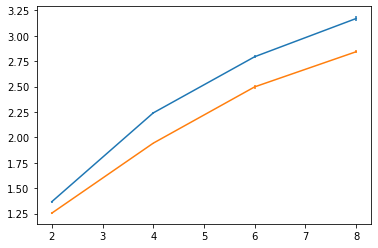

In [302]:
plt.errorbar(plens, mae_pitmodel[:,0], mae_pitmodel[:,1])
plt.errorbar(plens, mae_pitmodel[:,2], mae_pitmodel[:,3],)


<ErrorbarContainer object of 3 artists>

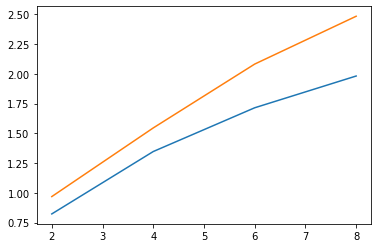

In [307]:
plt.errorbar(plens, mae[:,0], mae[:,1])
plt.errorbar(plens, mae[:,2], mae[:,3],)

In [344]:
stint_result.to_csv('stint_evalutate_result.csv')